In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split

In [2]:
#read train data, validate data and test data
train_data = pd.read_csv("train_data.csv",header=0)
val_data = pd.read_csv("validate_data.csv",header=0)
test_data = pd.read_csv("test_data.csv",header=0)

#train data
X_train = train_data[["actor_rating", "director_rating", "region_rating", "writer_rating", "date"]].values
y_train = train_data[["movie_rating"]].values

#validation data
X_val = val_data[["actor_rating", "director_rating", "region_rating", "writer_rating", "date"]].values
y_val = val_data[["movie_rating"]].values

#test data
X_test = test_data[["actor_rating", "director_rating", "region_rating", "writer_rating", "date"]].values
y_test = test_data[["movie_rating"]].values

In [3]:
#<Zihan Dai> (<2020/11>) <ridge_regression> [<.ipynb>]. Machine learning course Assignment2.
class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)


def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation、
    
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-2.5,-1.5,0.005),)))}]
    
    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)
    df = pd.DataFrame(grid.cv_results_)
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

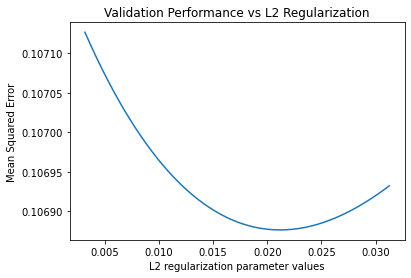

,param_l2reg,mean_test_score,mean_train_score
0,0.003162,0.107127,0.115302
1,0.003199,0.107126,0.115302
2,0.003236,0.107125,0.115302
3,0.003273,0.107123,0.115302
4,0.003311,0.107122,0.115302
...,...,...,...
195,0.029854,0.106918,0.115776
196,0.030200,0.106922,0.115785
197,0.030549,0.106925,0.115794
198,0.030903,0.106929,0.115804


In [4]:
#<Zihan Dai> (<2020/11>) <ridge_regression> [<.ipynb>]. Machine learning course Assignment2.
#Run ridge regression on the provided training dataset.  Choose the λ that minimizes
#the empirical risk (i.e.  the average square loss) on the validation set.
grid,df_toshow=do_grid_search_ridge(X_train, y_train, X_val, y_val)

plt.plot(df_toshow['param_l2reg'],df_toshow['mean_test_score'])
plt.title("Validation Performance vs L2 Regularization")
plt.ylabel('Mean Squared Error')
plt.xlabel('L2 regularization parameter values')
plt.show()

df_toshow

Choose λ = 0.021

In [5]:
#compute ridge regression MSE of validation set
l2reg = 0.021
ridge_regression_estimator = RidgeRegression(l2reg)
ridge_regression_estimator.fit(X_train, y_train)
y_val_pred = ridge_regression_estimator.predict(X_val)
MSE = 0
for i in range(len(y_val_pred)):
    MSE += (y_val_pred[i]-y_val[i][0])**2
MSE /= len(y_val_pred)
print("MSE of ridge regression =",MSE)

MSE of ridge regression = 0.10687640117775488


In [6]:
#ridge regression

#train model
l2reg = 0.021
ridge_regression_estimator = RidgeRegression(l2reg)
ridge_regression_estimator.fit(X_train, y_train)
y_pred = ridge_regression_estimator.predict(X_test)

#compute MSE
MSE = 0
for i in range(len(y_pred)):
    MSE += (y_pred[i]-y_test[i][0])**2
MSE /= len(y_pred)

#show predictions
np.set_printoptions(threshold=np.inf)   #show all data
print("MSE = {}".format(MSE))
print(ridge_regression_estimator.w_)
print(y_pred)

MSE = 0.11821324303412402
[ 3.23178744e-01  3.06020737e-01 -1.14617438e-01  5.04578007e-01
 -6.58510618e-05]
[6.19748611 7.24437708 8.33683388 8.23640155 6.12149475 7.93494617
 5.39196671 7.78473879 7.56483218 5.96636931 5.59223141 8.0380214
 7.70825652 6.70025367 4.17615011 7.96925048 5.77079568 5.40195771
 5.11477406 2.98718446 7.59520803 7.36818913 7.00149631 6.41358022
 4.77464082 8.12335294 7.82242673 7.65985101 7.00734104 6.68218133
 6.53599853 5.36139953 5.01260349 3.01937063 9.24052862 8.31861759
 8.25142826 8.11336201 7.82822024 7.65978516 7.6401266  7.69828326
 7.09289642 6.97958452 6.9939264  6.91487569 6.86600922 6.63901334
 6.53231009 5.55460611 2.84735079 8.83933989 8.60543695 8.10635603
 7.76726476 7.81172686 7.57429563 7.59520803 7.43939793 7.47146207
 7.24490397 6.99493628 6.91124253 6.79139297 6.62591159 6.67781767
 6.67808107 6.52550389 6.32634387 6.23199227 5.77466077 5.46611449
 5.45484146 5.21447286 5.10050245 4.64738664 4.3716329  3.41423954
 3.27628765 3.1733441

In [7]:
#show original ratings
np.set_printoptions(threshold=np.inf)   #show all data
y_test = y_test.reshape(-1)
print(y_test)

[6.  7.1 8.2 8.1 6.2 7.8 5.6 7.7 7.5 6.1 5.8 7.8 7.6 6.3 4.5 7.9 5.8 5.6
 5.3 3.4 7.5 7.3 7.  6.5 5.  8.  7.9 7.6 7.  6.7 6.6 5.6 5.2 3.5 9.  8.3
 8.1 8.  7.8 7.6 7.6 7.5 7.1 7.  7.  6.9 6.9 6.6 6.6 5.7 3.3 8.8 8.3 8.
 7.7 7.6 7.5 7.5 7.4 7.3 7.1 7.  6.7 6.7 6.6 6.6 6.6 6.5 6.4 6.3 6.  5.6
 5.6 5.4 5.3 4.9 4.7 3.8 3.6 3.6 3.3 2.3 2.2 9.2 9.  9.  8.7 8.7 8.6 8.
 8.  8.  7.9 7.9 7.8 7.5 7.4 7.4 7.3 7.2 7.2 7.  7.  7.  6.9 6.9 6.8 6.8
 6.6 6.6 8.5 7.1 9.3 6.7 9.1 7.7 7.7 8.2 8.6 6.7 6.5 8.5 8.  7.2 7.2 8.5
 6.4 7.8 7.3 8.8 7.1 8.5 6.9 7.4 4.7 7.8 7.9 6.7 6.9 5.2 7.6 8.  7.1 7.8
 7.7 5.5 8.3 7.  7.7 7.4 8.2 7.8 6.9 8.3 7.5 7.6 7.  6.9 6.5 7.5 7.  7.6
 6.9 7.1 6.5 7.4 5.6 7.9 6.9 6.7 4.3 6.4 8.9 6.5 6.9 7.8 6.9 6.2 7.1 6.2
 6.1 6.7 9.1 7.7 5.7 5.7 7.1 6.7 6.6 6.2 8.1 6.9 9.3 7.1 7.7 6.3 7.3 7.3
 6.8 7.3 8.2 5.6 6.4 5.3 7.4 7.5 7.  8.  6.5 8.  8.2 7.7 7.8 6.2 8.4 8.
 6.1 6.3 6.8 4.9 7.2 7.8 8.3 7.8 6.4 7.3 6.8 8.1 8.8 7.1 5.9 6.3 6.7 7.3
 6.8 5.7 6.9 5.2 7.2 7.  7.  5.4 8.1 6.1 8.  7.2 6.8 6

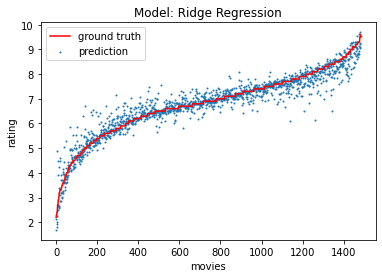

In [8]:
# plot
truth = y_test
truth_arg = truth.argsort()
truth.sort()
pred = [y_pred[arg] for arg in truth_arg]
N = [i for i in range(len(y_test))]
plt.scatter(N, pred, s=1)
plt.plot(N, truth, 'r')
plt.title("Model: Ridge Regression")
plt.xlabel("movies")
plt.ylabel("rating")
plt.legend(("ground truth", "prediction"))
plt.savefig("ridge_regression.png", dpi=400)
plt.show()